In [1]:
%load_ext autoreload
%autoreload 2

import torch

from models import BiAA, SBM, DBiAA, DSBM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
import sys
sys.path.append('/Users/aleix11alcacer/Projects/archetypes')

In [3]:
n_archetypes = (3, 3)

## Generating a stochastic block model graph

In [4]:
from archetypes.datasets import make_archetypal_dataset, shuffle_dataset
from archetypes.visualization import heatmap

# define a numpy generator
# generator = np.random.default_rng(9)
generator = np.random.default_rng(24)


archetypes = generator.uniform(0, 1, n_archetypes)
uniform_low = generator.uniform(0, 0.2, n_archetypes)
uniform_high = generator.uniform(0.75, 1, n_archetypes)

archetypes = np.where(archetypes < 0.8, uniform_low, uniform_high)

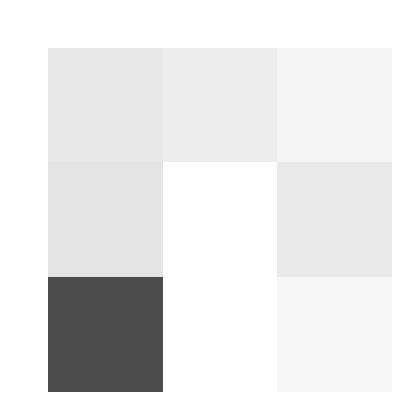

In [5]:
heatmap(archetypes, vmin=0, vmax=1)
plt.show()

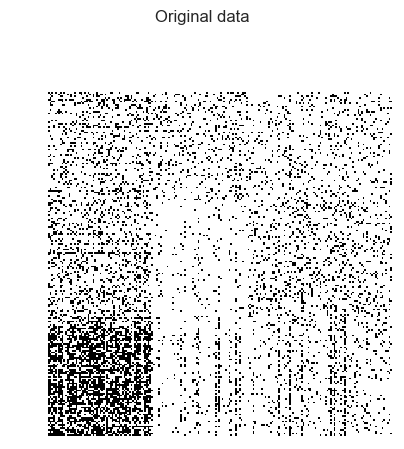

In [6]:
shape = (200, 200)

data, labels = make_archetypal_dataset(
    archetypes,
    shape,
    alpha=.1,
    generator=generator,
    noise=0
)

data = np.clip(data, 0, 1)

data = generator.binomial(1, data)  # binarize the data


ax = heatmap(data)
ax.set_title("Original data")

plt.show()

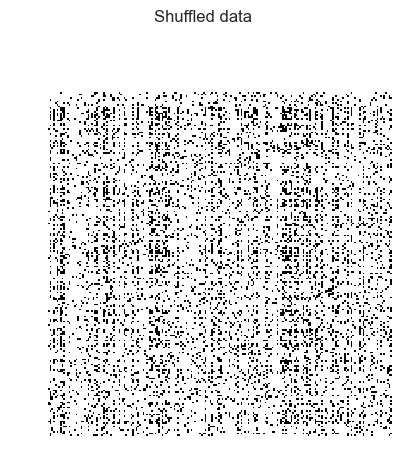

In [7]:
data_shuffle, info_shuffle = shuffle_dataset(data, generator=generator)

ax = heatmap(data_shuffle)
ax.set_title("Shuffled data")

plt.show()



### Apply models

In [8]:
data_tensor = torch.tensor(data_shuffle, dtype=torch.float32)

In [9]:
assignments = ["soft", "hard", "soft-hard"]
models = [BiAA, SBM, DBiAA, DSBM]
results = None

biaa_model = None
for assignment in assignments:
    for model in models:
        print(f"Assignment: {assignment}")
        best_model = None
        for _ in range(3):
            if model in [BiAA, DBiAA]:
                model_i = model(n_archetypes, data_tensor, likelihood="bernoulli", assignment=assignment, device="cpu")
            else:
                model_i = model(n_archetypes, data_tensor, likelihood="bernoulli", assignment=assignment, device="cpu", 
                               biaa_model=biaa_model)
            model_i.fit(500, learning_rate=0.01, threshold=0)
            
            if not best_model or model_i.losses[-1] < best_model.losses[-1]:
                best_model = model_i
    
            # create a df with the results with three columns: assignment, iteration and model losses
            ressults_i = pd.DataFrame(best_model.losses[::10], columns=["loss"])
            ressults_i["assignment"] = assignment
            ressults_i["iteration"] = ressults_i.index
            ressults_i["model"] = model_i.__class__.__name__
            results = pd.concat([results, ressults_i], ignore_index=True)
            
            # plt.plot(best_model.losses, label=assignment)
            
        if model in [BiAA, DBiAA]:
            biaa_model = best_model


Assignment: soft
Assignment: soft
6403.802734375
6403.802734375
6538.79736328125
6538.79736328125
6478.10009765625
6478.10009765625
Assignment: soft
Assignment: soft
Assignment: hard
Assignment: hard
6608.384765625
6608.384765625
6608.384765625
6608.384765625
6608.384765625
6608.384765625
Assignment: hard
Assignment: hard
Assignment: soft-hard
Assignment: soft-hard
7713.3564453125
7713.3564453125
7713.3564453125
7713.3564453125
7713.3564453125
7713.3564453125
Assignment: soft-hard
Assignment: soft-hard


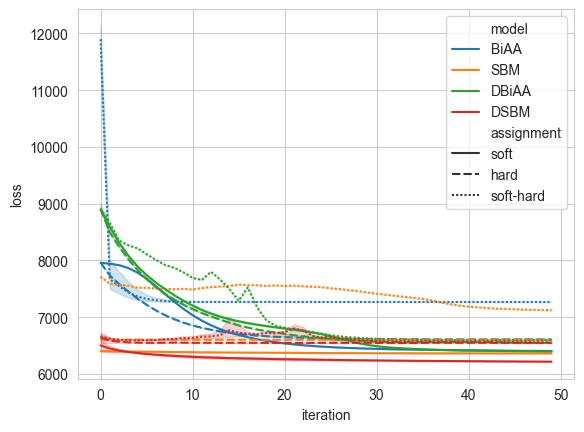

In [10]:
sns.lineplot(data=results, x="iteration", y="loss", hue="model", style="assignment")

plt.show()

In [11]:
true_labels = labels[0][info_shuffle["perms"][0]][info_sorted["perms"][0]]
pred_labels = info_sorted["labels"][0]
scores = info_sorted["scores"][0]

# select only labels that has a score grater than 0.9

thresh = 0.75
pred_labels = pred_labels[scores > thresh]
true_labels = true_labels[scores > thresh]
# compare labels using normalized mutual information

from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(true_labels, pred_labels)
print(f"Normalized mutual information: {nmi:.3f}")

NameError: name 'info_sorted' is not defined

In [ ]:
from sklearn.metrics import average_precision_score, roc_auc_score
from tqdm.notebook import tqdm
from itertools import product


a_zero = data_tensor.clone()
x1, y1 = np.where(data_tensor == 1)
i = np.random.choice(len(x1), round(len(x1) / 10), replace=False)
x1_i = x1[i]
y1_i = y1[i]
a_zero[x1_i, y1_i] = 0
x0, y0 = np.where(a_zero == 0)
y_true = data_tensor[x0, y0].detach().numpy().astype(bool)


k = 3

models = [BiAA, SBM, DBiAA, DSBM]
likelihoods = ["bernoulli"]
assignments = ["soft", "hard"]

auc_min, auc_max = np.inf, -np.inf
prauc_min, prauc_max = np.inf, -np.inf
auc = {}
prauc = {}

auc_k = {}
prauc_k = {}
for ass, mod, lik in tqdm(list(product(assignments, models, likelihoods)), leave=False):
# for ass, mod in tqdm(list(product(assignments, models)), leave=False):
    key = f"{mod.__name__}\n{ass}"

    for _ in tqdm(range(10), leave=False):
        auc_j = -np.inf
        prauc_j = -np.inf
        for i in tqdm(range(3), leave=False):
            model_i = mod(n_archetypes, a_zero, likelihood=lik, assignment=ass, device="cuda")
            model_i.fit(2_000, learning_rate=0.05, threshold=1e-2)

            if mod in [BiAA, SBM]:
                a_rec = model_i.A @ model_i.Z @ model_i.D
            else:
                a_rec = model_i.a[:, None] * model_i.A @ model_i.Z @ model_i.D * model_i.d[None, :]

            y_score = a_rec[x0, y0].cpu().detach().numpy()

            auc_i = roc_auc_score(y_true, y_score)
            prauc_i = average_precision_score(y_true, y_score)

            if auc_j < auc_i:
                auc_j = auc_i
            if prauc_j < prauc_i:
                prauc_j = prauc_i

        auc_k[key] = auc_k.get(key, []) + [auc_j]
        prauc_k[key] = prauc_k.get(key, []) + [prauc_j]
auc[k] = auc_k
prauc[k] = prauc_k


In [ ]:
# create plot

def grouped(iterable, n):
    return zip(*[iter(iterable)]*n)

def iterate_bplot(bplot): 
    boxes = bplot["boxes"]
    fliers = bplot["fliers"]
    medians = bplot["medians"]
    whiskers = grouped(bplot["whiskers"], 2)
    caps = grouped(bplot["caps"], 2)
    
    return zip(boxes, fliers, medians, whiskers, caps)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

bplot = ax.boxplot(pd.DataFrame(auc_k), patch_artist=True, labels=auc_k.keys())
ax.set_ylabel("ROC-AUC")
ax.set_xlabel(f"{k} groups")

auc_min = min([min(v) for v in auc_k.values()])
auc_max = max([max(v) for v in auc_k.values()])
   
auc_thresh = (auc_max - auc_min) * 0.05
ax.set_ylim(auc_min - auc_thresh, auc_max + auc_thresh)

# get matplotlib cmap
import matplotlib as mpl

cmap = mpl.colormaps["Set1"]
colors = cmap(np.linspace(0, 1, len(auc_k.keys()) // 2))

# repeat colors
colors = np.tile(colors, (2, 1))

for (box, flier, median, whiskers, caps), c in zip(iterate_bplot(bplot), colors):
    alpha = 0.25

    # convert c to rgb
    import matplotlib.colors as mcolors
    c1 = np.array(mcolors.to_rgb(c))
    c2 = alpha * c1 + (1 - alpha) * np.array([1, 1, 1])
    
    c1 = tuple(c1)
    c2 = tuple(c2)

    box.set_edgecolor(c1)
    box.set_facecolor(c2)
    
    flier.set_markeredgecolor(c1)
    flier.set_markerfacecolor(c2)
    
    median.set_color(c1)
    
    for whisker in whiskers:
        whisker.set_color(c1)
        
    for cap in caps:
        cap.set_color(c1)
        
# ax.set_ylim(bottom=.5, top=1)
plt.show()
